__Implement 4c, 4d, and 4f.  Plot graphs (histograms?) to show the sample data__

## Handling sample selection bias

The use of linear models, where possible, simplifies causal reasoning and allows one to use linear regression to determine path coefficients relating values.  They make life a lot easier.

This notebook shows how path coefficients are calculated on a synthetic dataset where we can control the correct values.  The dataset construction code is in dataset_N.py for N = 01, 02, 03 and useful functions are defined in causal_utils.py, all in the current directory.


In [1]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
from random import random, seed, uniform, gauss
import re
import sys

from sklearn.linear_model import LinearRegression
import causality


In [2]:
import causal_utils as u

In [3]:
# Set a seed so that the results are reproducible.  The value is arbitrary and everything works without it

seed(12345)
np.random.seed(12345)

In [4]:
%matplotlib inline

pd.options.display.max_rows = 250
pd.options.display.max_columns = 125
pd.options.display.max_colwidth = 250

nx_options = {
    'node_color': 'orange',
    "edge_color": "blue",
    "with_labels": True,
    "font_weight": 'bold',
    "font_size": 12,
    'node_size': 1200,
    'width': 1,
    "arrowsize": 15,
}

# The accuracy is okay with 100k observations but a milion is better.
num_data_elts = 1_000_000


In [5]:
dataset_index = 2

assert dataset_index in [1, 2]

In [6]:
if dataset_index == 1:
    import sample_selection_bias_dataset_01 as dataset
    from sample_selection_bias_dataset_01 import g, draw_fn, observation

elif dataset_index == 2:
    import sample_selection_bias_dataset_02 as dataset
    from sample_selection_bias_dataset_02 import g, draw_fn, observation


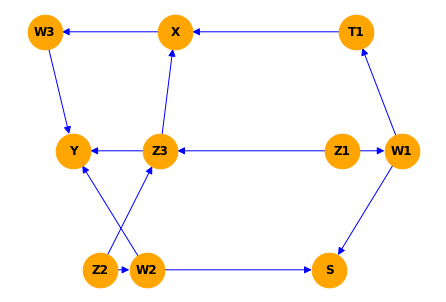

In [7]:
nx.draw_spectral(g, **nx_options)

In [8]:
data = [dataset.observation() for _ in range(num_data_elts)]
df = pd.DataFrame(data, columns=sorted(g.nodes))

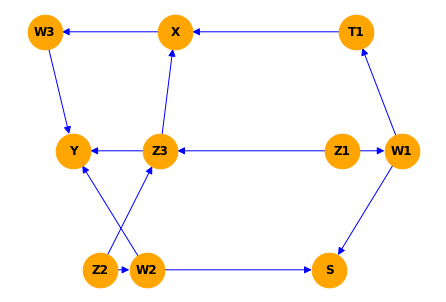

In [9]:
draw_fn(g, **nx_options)

In [10]:
dfs = df[df.S == 1]

In [11]:
df.shape, dfs.shape

((1000000, 10), (143294, 10))

In [15]:
if dataset_index == 1:
    controlled_sets = [
        ["X", "W1", "W2", "Z"],
        ["X", "W1", "W2"],
        ["X", "Z"],
    ]


In [66]:
if dataset_index == 2:
    controlled_sets = [
#         [],
        ["W2", "Z3"],
        ["Z1", "Z2", "Z3"],
#         ["T1", "W1", "W2", "Z1", "Z2", "Z3"],
    ]


In [67]:
# for control in controlled_sets:
#     print(control)
#     print("all  ", u.path_coefficients(df, "Y", control))
#     print("S = 1", u.path_coefficients(dfs, "Y", control))
#     print()


In [68]:
def control_for(controls, num_elements, x, dfx, z_freqs):
    if len(controls) == 0:
        if len(dfx.Y) > 0:
            model = LinearRegression().fit(dfx[["X"]], dfx.Y)
            predicted_value = model.predict([[x]])[0]
            
#             print("@@", predicted_value, z_freqs[0].sum(), num_elements)
            yield predicted_value * z_freqs[0].sum() / num_elements
    else:
        control_var, control_low, control_high = controls[0]
        

        for control_value in range(control_low, control_high + 1):
#             print("@", controls[0])

            yield from control_for(controls[1:], num_elements, x,
                                   dfx[dfx[control_var] == control_value],
                                   z_freqs.loc[control_value])


In [72]:
for controls in controlled_sets:
    print(controls)
    dfp = df[df.S == 0]
    
    z_freqs = dfp[controls].groupby([dfp[var] for var in controls]).count()

    print(sum(control_for([(var, dfp[var].min(), dfp[var].max()) for var in controls],
                len(dfp), 1,
                dfs,
                z_freqs)))


['W2', 'Z3']
2.4546636852832564
['Z1', 'Z2', 'Z3']
8.68174620877786


In [70]:
dfp.shape, dfs.shape

((856706, 10), (143294, 10))

In [62]:
[(var, dfs[var].min(), dfs[var].max()) for var in controls]

[('Z1', -1, 1), ('Z2', 0, 4), ('Z3', 0, 3)]

In [21]:

print("empirical value of Y for X = 1:")
for _ in range(5):
    dfx = u.do_value_dataframe(g, dataset, "X_value", lambda *args: 1, 1_000_000)

    print(dfx[dfx.S == 1].Y.mean())


empirical value of Y for X = 1:
8.59841615132588
8.621570405568196
8.625202685263197
8.613759676987195
8.60954982583353
